Подключите нужные библиотеки и убедитесь в правильности выбранного устройства. Для начала советую писать на cpu, а на видеокарту переключаться, когда большая часть кода будет готова, чтобы не расходовать лишний ресурс. Чтобы подключить видеокарту, необходимо в настройках сменить среду выполнения на T4GPU. Если видеокарта подключилась успешно, блок кода ниже напечатает cuda.

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


Для начала разберемся с данными. Мы будем использовать датасет mnist, картинки рукописных надписей десятичных цифр.

In [ ]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 93.5MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 22.1MB/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 96.9MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.29MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
print(X_batch.shape, y_batch.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


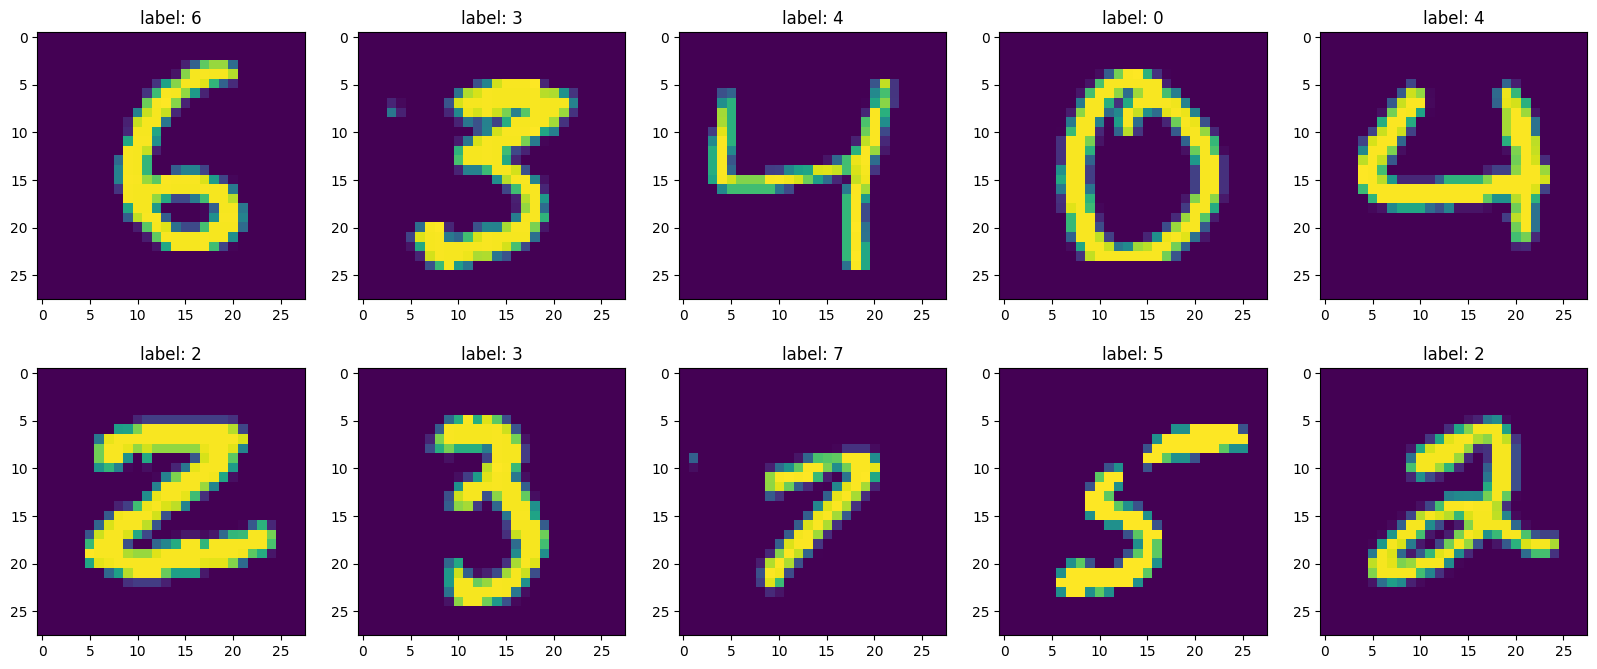

In [ ]:
indexes = np.random.randint(X_batch.shape[0], size = 10)
plt.figure(figsize=(20, 8))
for i, index in enumerate(indexes):
  x = plt.subplot(2, 5, i+1)
  x.title.set_text(f"label: {y_batch[index]}")
  plt.imshow(X_batch[index][0])
plt.show()

Как видно с печатей, mnist состоит из одноканальных изображений 28x28 пикселей. Ваша задача - научить свои модели определять цифру на картинке.

Для начала реализуем класс линейной регрессии, используя возможности PyTorch. Дополните код ниже до корректной работы.

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_weights = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x = x + self.bias_weights # todo - добавьте сдвиг к результату
        return x

На практике, вместо своего класса можно использовать nn.Linear, обладающий такой же сигнатурой.

In [ ]:
linear_model = nn.Sequential(
    nn.Flatten(),
    LinearRegression(28 ** 2, 10) # классификация на 10 классов, значит и выходов столько же
).to(device) # так мы перемещаем модель на видеокарту

optimizer = torch.optim.Adam(linear_model.parameters())

criterion = nn.CrossEntropyLoss()

Sequential последовательно применит свои аргументы к пропускаемым через него аргументам, его удобно использовать для создания простых моделей или блоков внутри сложных. В качестве функции потерь берем стандартную для классификаторов кросс-энтропию. В качестве метрики будем использовать обычную accuracy, ее легко реализовать руками.

In [ ]:
def learning_loop(tr_loader, val_loader, model, loss_fn, optim, epochs=20):
    tr_history = []
    val_history = []

    for epoch in range(epochs):
        tr_loss, tr_acc = train_epoch(tr_loader, model, loss_fn, optim)
        val_loss, val_acc = eval_epoch(val_loader, model, loss_fn)

        tr_history.append((tr_loss, tr_acc))
        val_history.append((val_loss, val_acc))

        print(f"epoch: {epoch + 1}; losses: {tr_loss}, {val_loss}; accuracy: {tr_acc}, {val_acc}")

    return tr_history, val_history



In [ ]:
def train_epoch(data_loader, model, loss_fn, optim):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    for x_batch, y_batch in data_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device) # перебрасываем входные данные на gpu
        optim.zero_grad() # обнуляем градиенты

        logits = model(x_batch)
        loss = loss_fn(logits, y_batch) # в данном случае лосс заточен на логиты, и сам применит softmax
        loss.backward() # пробрасываем градиенты
        optim.step() # делаем шаг оптимизатора

        loss_val = loss.item()
        preds = logits.argmax(-1)
        correct = preds == y_batch

        # todo - посчитайте полные loss и accuracy за всю эпоху обучения. Верните их результатами функции.
        total_loss += loss.item() * x_batch.size(0) # Учитываем размер батча
        correct_predictions += correct.sum().item()
        total_samples += x_batch.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy



In [ ]:
def eval_epoch(data_loader, model, loss_fn):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    for x_batch, y_batch in data_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        with torch.set_grad_enabled(False): # на валидации модель не должна учиться, градиенты не считаем
            logits = model(x_batch)         # оптимизатор в функцию вовсе не передается
            loss = loss_fn(logits, y_batch)

        # допишите функцию аналогично предыдущей, с такими же возвращаемыми занчениями.
        total_loss += loss.item() * x_batch.size(0) # Учитываем размер батча
        preds = logits.argmax(-1)
        correct = preds == y_batch
        correct_predictions += correct.sum().item()
        total_samples += x_batch.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy



In [ ]:
epochs = 20
train_history, val_history = learning_loop(train_dataloader, valid_dataloader, linear_model, criterion, optimizer, epochs=epochs)
train_losses, train_accuracies = zip(*train_history)
val_losses, val_accuracies = zip(*val_history)


epoch: 1; losses: 11.415511554718018, 4.791596487426758; accuracy: 0.3626333333333333, 0.563
epoch: 2; losses: 3.6581556001027424, 2.5425970610618593; accuracy: 0.6454833333333333, 0.7208
epoch: 3; losses: 2.397557286643982, 1.877033816242218; accuracy: 0.7443833333333333, 0.7825
epoch: 4; losses: 1.9008133701324463, 1.5537315455913543; accuracy: 0.78905, 0.8152
epoch: 5; losses: 1.6220860363006593, 1.35354878282547; accuracy: 0.8132833333333334, 0.8338
epoch: 6; losses: 1.436137344678243, 1.2221506805181503; accuracy: 0.8290333333333333, 0.8471
epoch: 7; losses: 1.3016069575627645, 1.1274432275533677; accuracy: 0.8407333333333333, 0.8579
epoch: 8; losses: 1.198805562019348, 1.05372795522213; accuracy: 0.84965, 0.8666
epoch: 9; losses: 1.1163348385492962, 0.9958735337167979; accuracy: 0.8564, 0.8724
epoch: 10; losses: 1.0480782690684, 0.9487889744967222; accuracy: 0.8613166666666666, 0.8757
epoch: 11; losses: 0.990538658396403, 0.9089066424682737; accuracy: 0.8658166666666667, 0.8785
e

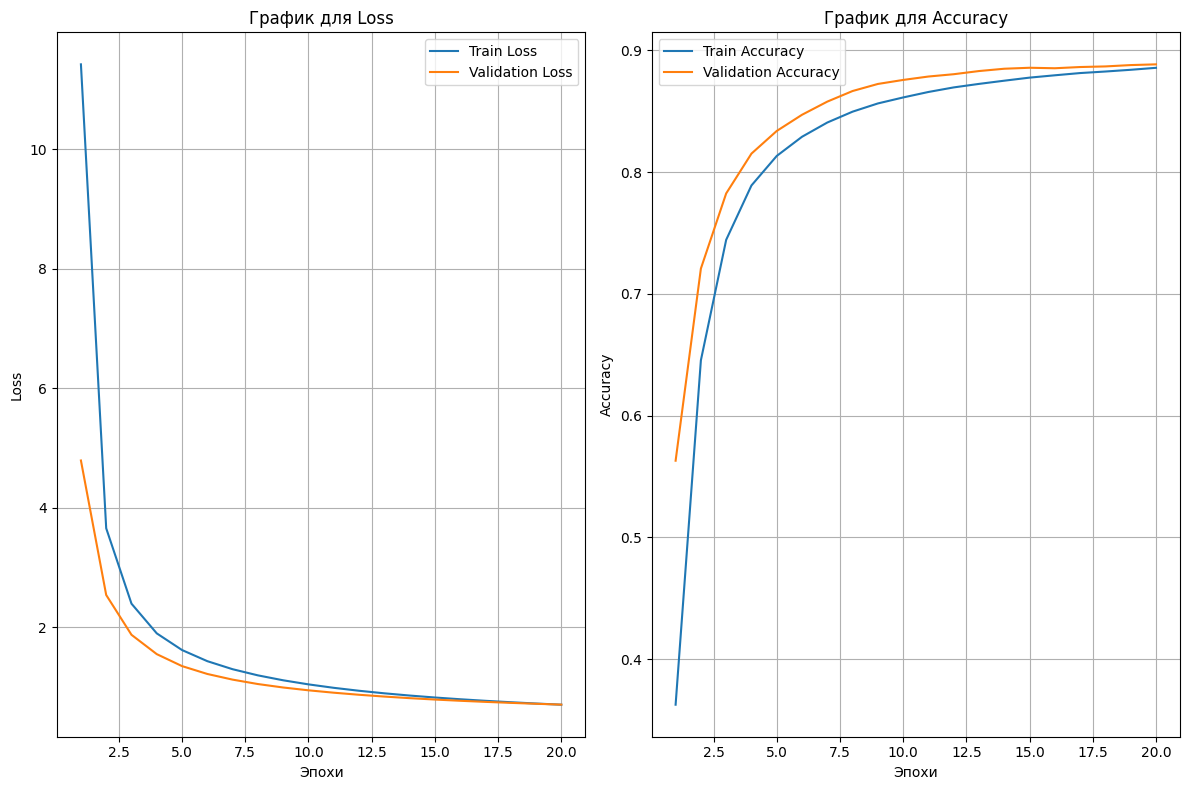

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Эпохи")
plt.ylabel("Loss")
plt.title("График для Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Эпохи")
plt.ylabel("Accuracy")
plt.title("График для Accuracy")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
class DenseNetwork(nn.Module):
    def __init__(self, in_features=28**2, out_features=10, activ=None):
        super().__init__()
        if activ is None:
            activ = nn.ReLU()
        self.flat = nn.Flatten()
        self.activ = activ
        self.linear_1 = nn.Linear(in_features, 128)
        self.linear_2 = nn.Linear(128, 128)
        self.linear_3 = nn.Linear(128, out_features)

    def forward(self, x):
        x = self.flat(x)
        # todo - допишите руками проход аргументов через все слои
        x = self.activ(self.linear_1(x))
        x = self.activ(self.linear_2(x))
        x = self.linear_3(x)

        return x

Можно ли было в данном случае не писать класс, а просто применить Sequential? Да, но оформив модель через класс мы имеем возможность потом модифицировать поведение уже обученной модели, обратившись к её полям.

In [ ]:
model = DenseNetwork(in_features=28**2, out_features=10, activ=nn.ReLU()).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
epochs = 20
train_history1, val_history1 = learning_loop(train_dataloader, valid_dataloader, model, criterion, optimizer, epochs=epochs)


epoch: 1; losses: 0.44904717932542165, 0.27123096549510955; accuracy: 0.8664833333333334, 0.9153
epoch: 2; losses: 0.2237073221206665, 0.17786826442182063; accuracy: 0.9331166666666667, 0.9443
epoch: 3; losses: 0.16031938968102138, 0.1485121098563075; accuracy: 0.9515666666666667, 0.9561
epoch: 4; losses: 0.12501210472981136, 0.13575094643682242; accuracy: 0.96265, 0.9587
epoch: 5; losses: 0.10329120782613754, 0.13077835001423954; accuracy: 0.96915, 0.9612
epoch: 6; losses: 0.08801722536981106, 0.1149109393067658; accuracy: 0.9728833333333333, 0.9658
epoch: 7; losses: 0.07799131614764532, 0.11246798449121416; accuracy: 0.9756833333333333, 0.9678
epoch: 8; losses: 0.06950119622374575, 0.10868914473317563; accuracy: 0.9786833333333333, 0.9681
epoch: 9; losses: 0.06213271572391192, 0.10908592812954448; accuracy: 0.9804833333333334, 0.9674
epoch: 10; losses: 0.05840985812991858, 0.11598047585058957; accuracy: 0.9814833333333334, 0.9669
epoch: 11; losses: 0.05130083458373944, 0.102271756440

In [ ]:
train_losses1, train_accuracies1 = zip(*train_history1)
val_losses1, val_accuracies1 = zip(*val_history1)

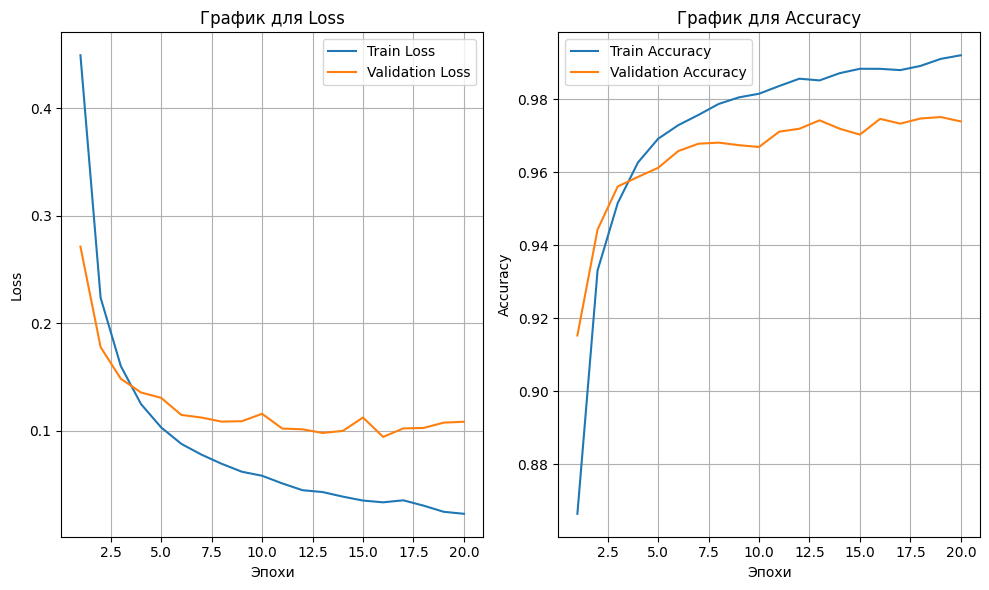

In [ ]:
# todo - обучите модель, постройте графики обучения.
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses1, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses1, label="Validation Loss")
plt.xlabel("Эпохи")
plt.ylabel("Loss")
plt.title("График для Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies1, label="Train Accuracy")
plt.plot(range(1, epochs + 1), val_accuracies1, label="Validation Accuracy")
plt.xlabel("Эпохи")
plt.ylabel("Accuracy")
plt.title("График для Accuracy")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

Создайте новые модели с другими функциями активации. Попробуйте: гиперболический тангенс, сигмоиду, ELU, LeakyReLU. Все их можно найти в torch.nn.functional. Обучите их, постройте и сравните между собой графики обучения.

In [ ]:
# todo
func = {
    "ReLU": F.relu,
    "Tanh": F.tanh,
    "Sigmoid": F.sigmoid,
    "ELU": F.elu,
    "LeakyReLU": F.leaky_relu}
results = {}

for name, activation in func.items():
    model = DenseNetwork(activ=activation).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    train_history, val_history = learning_loop(train_dataloader, valid_dataloader, model, criterion, optimizer, epochs=20)
    results[name] = (train_history, val_history)

epoch: 1; losses: 0.44530788554350537, 0.24719014681577683; accuracy: 0.8684666666666667, 0.9242
epoch: 2; losses: 0.2209661126414935, 0.18206747846603394; accuracy: 0.93415, 0.9422
epoch: 3; losses: 0.15403750519951184, 0.14697428592294454; accuracy: 0.9537333333333333, 0.9537
epoch: 4; losses: 0.11924480260411899, 0.11831488793715834; accuracy: 0.9640166666666666, 0.9627
epoch: 5; losses: 0.09928653726577759, 0.11387636340409517; accuracy: 0.97, 0.9646
epoch: 6; losses: 0.08533806138436, 0.1006173993691802; accuracy: 0.9739666666666666, 0.969
epoch: 7; losses: 0.0732791936715444, 0.09795478189382702; accuracy: 0.9777833333333333, 0.9692
epoch: 8; losses: 0.06287503430147966, 0.09365396568302531; accuracy: 0.9805666666666667, 0.9725
epoch: 9; losses: 0.054828157896300155, 0.09627667473282199; accuracy: 0.9825833333333334, 0.9705
epoch: 10; losses: 0.0501644239174823, 0.09037816723713185; accuracy: 0.9840333333333333, 0.9747
epoch: 11; losses: 0.04422078065971533, 0.1120576901249704; a

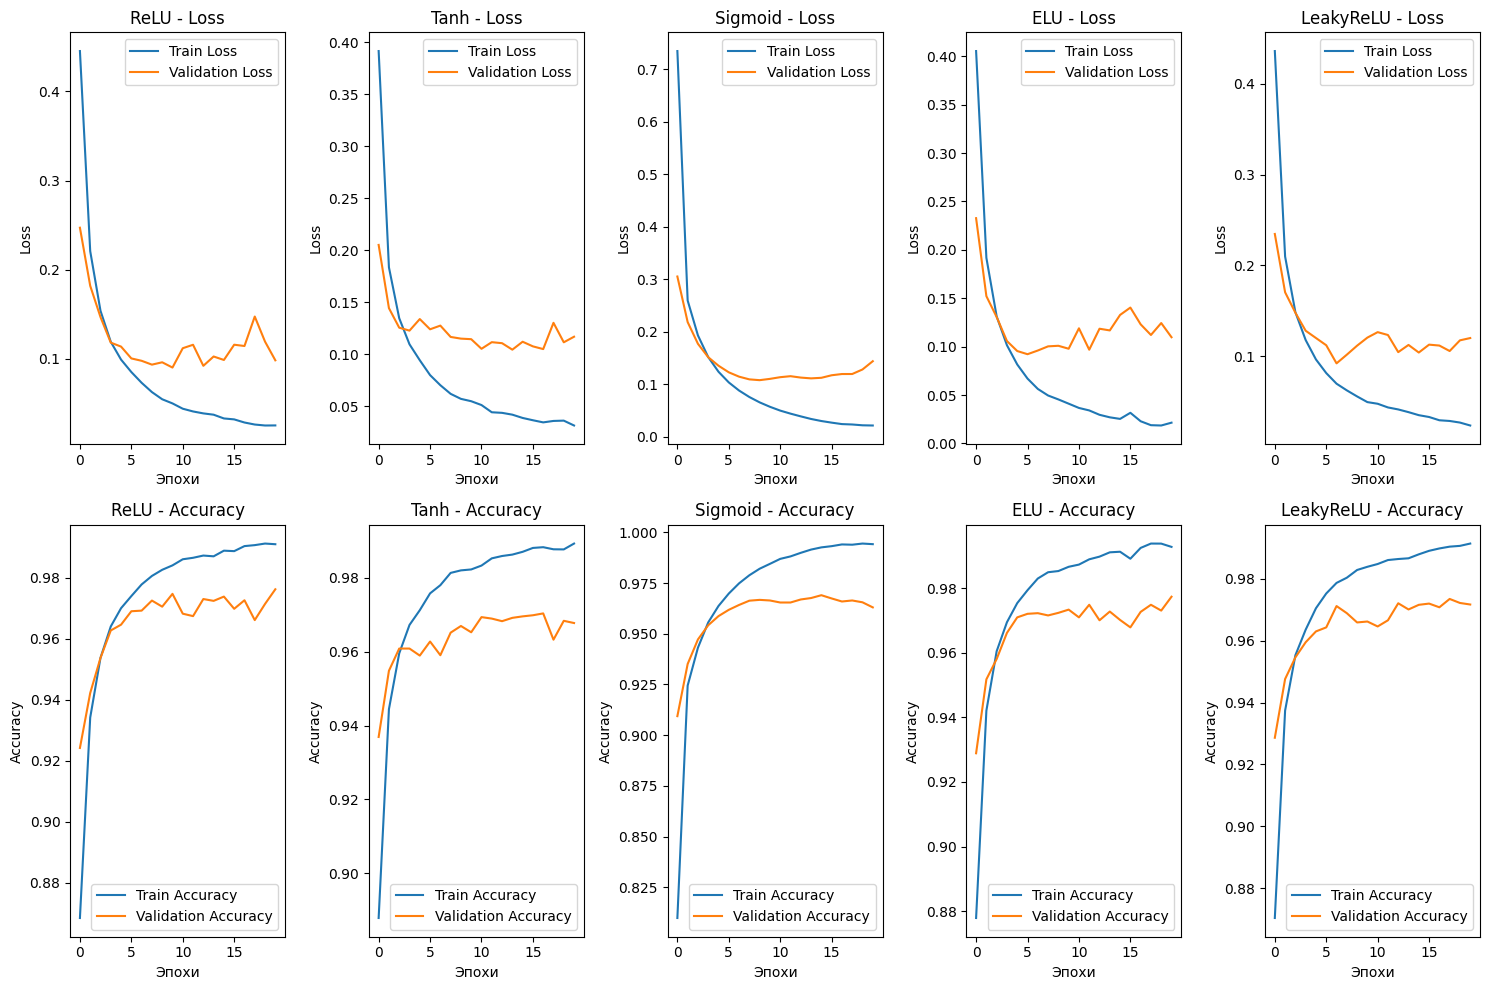

In [ ]:
plt.figure(figsize=(15, 10))

for i, (name, (train_history, val_history)) in enumerate(results.items()):
    train_losses, train_accs = zip(*train_history)
    val_losses, val_accs = zip(*val_history)

    plt.subplot(2, len(func), i + 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{name} - Loss')
    plt.xlabel('Эпохи')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, len(func), i + 1 + len(func))
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title(f'{name} - Accuracy')
    plt.xlabel('Эпохи')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

Теперь вам предстоит написать свою первую сверточную нейросеть. Превая версия архитектура LeNet была предложена еще аж в 1998 году. Вам предлагается реализовать её в таком виде:


*   Свертки 3x3 переход из 1 карты в 6 + ReLU
*   MaxPooling 2x2
*   Свертки 3x3 переход из 6 карт в 16 + ReLU
*   MaxPooling 2x2
*   Выпрямление (flatten)
*   Полносвязный слой, 120 нейронов + ReLU
*   Полносвязный слой, 84 нейрона + ReLU
*   Классификационный слой, 10 нейронов

Свертки можно брать из nn.Conv2d, пулинг - из nn.MaxPool2d, их сигнатуры можно загуглить.





In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        # todo - реализовать архитектуру LeNet
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Прямой проход через слои
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# todo - обучите модель, постройте графики обучения.
lenet_model = LeNet().to(device)
optimizer = torch.optim.Adam(lenet_model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 20
train_history, val_history = learning_loop(train_dataloader, valid_dataloader, lenet_model, criterion, optimizer, epochs)
train_losses, train_accs = zip(*train_history)
val_losses, val_accs = zip(*val_history)



epoch: 1; losses: 0.40707561496992906, 0.12689597819447518; accuracy: 0.8815, 0.9594
epoch: 2; losses: 0.1027093367189169, 0.08631216166913509; accuracy: 0.9682833333333334, 0.9724
epoch: 3; losses: 0.07037743185361227, 0.05662623527161777; accuracy: 0.97825, 0.9817
epoch: 4; losses: 0.054678611340001224, 0.04822304346319288; accuracy: 0.9832666666666666, 0.9845
epoch: 5; losses: 0.044002372915235656, 0.049775983644789086; accuracy: 0.9869, 0.9837
epoch: 6; losses: 0.036134852529658625, 0.04611077768849209; accuracy: 0.9890166666666667, 0.9848
epoch: 7; losses: 0.029967145449497426, 0.046236550775764045; accuracy: 0.9909333333333333, 0.986
epoch: 8; losses: 0.024735946033871734, 0.04785813348692609; accuracy: 0.9926333333333334, 0.9867
epoch: 9; losses: 0.020965293942019344, 0.05348335375690367; accuracy: 0.9935, 0.9853
epoch: 10; losses: 0.01844576397074076, 0.05479236485423462; accuracy: 0.994, 0.9852
epoch: 11; losses: 0.01684532951452226, 0.052892213501458174; accuracy: 0.994166666

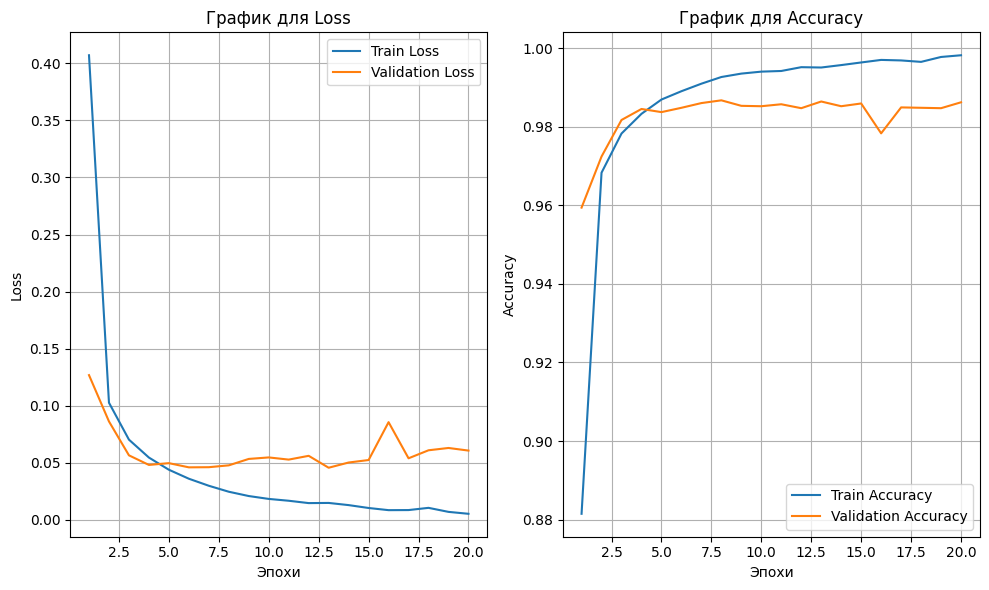

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Эпохи")
plt.ylabel("Loss")
plt.title("График для Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accs, label="Train Accuracy")
plt.plot(range(1, epochs + 1), val_accs, label="Validation Accuracy")
plt.xlabel("Эпохи")
plt.ylabel("Accuracy")
plt.title("График для Accuracy")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

Проанализируйте полученные результаты, постройте сравнительные графики для точности на валидационной выборке у трех разных моделей. В качестве задачи со звездочкой, можете попробовать поиграть со своей архитектурой сверточной нейронной сети (можно варьировать количество слоев, количество нейронов в них, добавлять в свертки padding, а в полносвязную часть skip-connections).

In [ ]:
epochs = 20
train_history_lin, val_history_lin = learning_loop(train_dataloader, valid_dataloader, linear_model, criterion, optimizer, epochs=epochs)
train_losses_lin, train_accuracies_lin = zip(*train_history_lin)
val_losses_lin, val_accuracies_lin = zip(*val_history_lin)

epoch: 1; losses: 5.93211761118571, 3.66793621635437; accuracy: 0.5110333333333333, 0.6346
epoch: 2; losses: 3.0621113838831584, 2.402547702026367; accuracy: 0.68625, 0.7397
epoch: 3; losses: 2.22397188911438, 1.8941898092269898; accuracy: 0.7560666666666667, 0.7854
epoch: 4; losses: 1.827836283906301, 1.6093877203941345; accuracy: 0.7925833333333333, 0.8124
epoch: 5; losses: 1.584458815987905, 1.4217879518508911; accuracy: 0.8141, 0.8285
epoch: 6; losses: 1.414493015797933, 1.2863875208258628; accuracy: 0.8291666666666667, 0.8426
epoch: 7; losses: 1.2874558248837789, 1.1843944306492806; accuracy: 0.83925, 0.8509
epoch: 8; losses: 1.1879647643089295, 1.104429207289219; accuracy: 0.8476, 0.8573
epoch: 9; losses: 1.1077907517433168, 1.0404537475585938; accuracy: 0.8537833333333333, 0.863
epoch: 10; losses: 1.0416423731644948, 0.9886952284574508; accuracy: 0.8591166666666666, 0.8672
epoch: 11; losses: 0.9860080700874329, 0.9457228646457195; accuracy: 0.8627333333333334, 0.8713
epoch: 12; 

In [ ]:
model = DenseNetwork(in_features=28**2, out_features=10, activ=nn.ReLU()).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train_history_dence, val_history_dence = learning_loop(train_dataloader, valid_dataloader, model, criterion, optimizer, epochs=epochs)
train_losses_dence, train_accuracies_dence = zip(*train_history_dence)
val_losses_dence, val_accuracies_dence = zip(*val_history_dence)

epoch: 1; losses: 0.4571305781364441, 0.2503716624498367; accuracy: 0.8640833333333333, 0.9239
epoch: 2; losses: 0.22686520404815674, 0.16345336627066134; accuracy: 0.9312833333333334, 0.9494
epoch: 3; losses: 0.159518157996734, 0.1404410036623478; accuracy: 0.9512333333333334, 0.9546
epoch: 4; losses: 0.12563169156412285, 0.13195764861404896; accuracy: 0.96195, 0.9568
epoch: 5; losses: 0.10421197361648082, 0.11857641382664443; accuracy: 0.9678166666666667, 0.9611
epoch: 6; losses: 0.08826091352303823, 0.11592668876983225; accuracy: 0.9727833333333333, 0.9618
epoch: 7; losses: 0.07636188688079516, 0.11112907997630536; accuracy: 0.9765166666666667, 0.9644
epoch: 8; losses: 0.0674435388147831, 0.10584986081682146; accuracy: 0.9792333333333333, 0.9672
epoch: 9; losses: 0.061267015546063584, 0.11698267196677625; accuracy: 0.9808166666666667, 0.9651
epoch: 10; losses: 0.058393020302057265, 0.11139229026604444; accuracy: 0.9807333333333333, 0.9656
epoch: 11; losses: 0.0516016997585694, 0.110

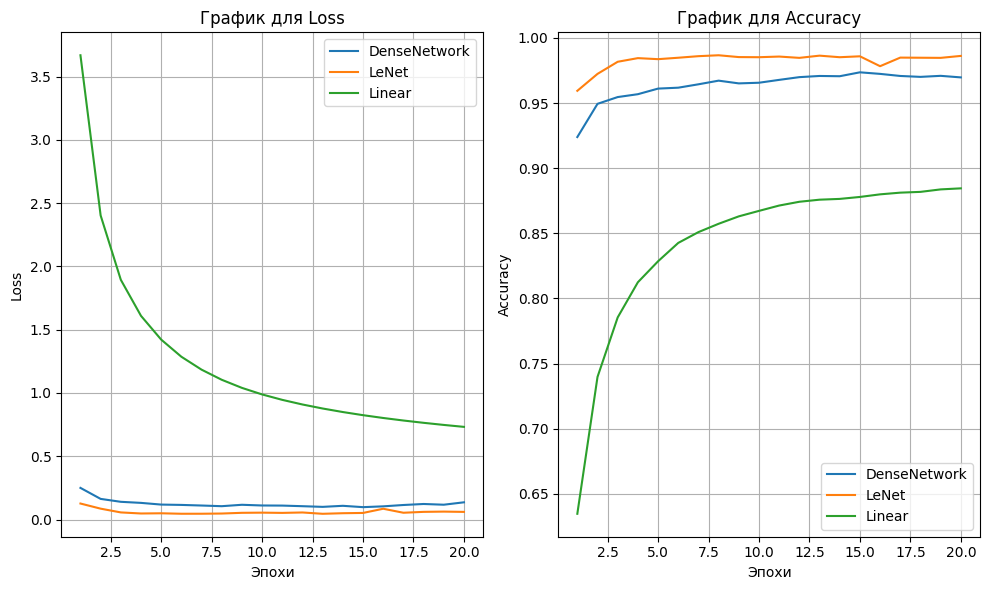

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), val_losses_dence, label="DenseNetwork")
plt.plot(range(1, epochs + 1), val_losses, label="LeNet")
plt.plot(range(1, epochs + 1), val_losses_lin, label="Linear")
plt.xlabel("Эпохи")
plt.ylabel("Loss")
plt.title("График для Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1),  val_accuracies_dence, label="DenseNetwork")
plt.plot(range(1, epochs + 1), val_accs, label="LeNet")
plt.plot(range(1, epochs + 1),  val_accuracies_lin, label="Linear")
plt.xlabel("Эпохи")
plt.ylabel("Accuracy")
plt.title("График для Accuracy")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

Линейная модель - самая простая в реализации и показывает худшие результаты по функции потерь и точности. График Loss показывает, как уменьшается функция потерь во время обучения. И как раз линейная модель показывает самые большие значения, особенно при малых эпохах.
График Accuracy показывает, как растет точность модели во время обучения. Как и ожидалось, свёрточная модель лучше всего работает с изображениями, что видно на обоих графиках.